
<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Using ABBA to Classify, and Predict Time Series Via LLMs -> [The Ralated Article](https://arxiv.org/abs/2411.18506)🤙


In this notebook and tutorial, we will fine-tune the [Mistral 7B](https://github.com/mistralai/mistral-src) model to classify and predict time series.

**Watch an accompanying video walk-through (but for using your own data) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)!** If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb).

This tutorial will use [QLoRA](https://arxiv.org/abs/2305.14314), a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` (`Mistral-7B-v0.1`) and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

ABBA->LLM->ABBA


<img src="figure1.png" width="90%">

Figure1. The model framework of LLM-ABBA: Given an input time series, we first transform and compress the time series to a symbolic series via <span style="color: red;">1</span>. These symbolic series will be tokenized by the LLM's tokenizer via <span style="color: red;">2</span>. The designed instruction that contains these symbolic series also will be tokenized by the LLM's tokenizer. Additionally, by only fine-tuning the pretrained LLM, the QLoRA with inhibition mechanism is utilized both in <span style="color: red;">3</span>. To implement the corresponding tasks, LLMs will first generate the symbolic series with Instruction via <span style="color: red;">4</span> and <span style="color: red;">5</span> uses ABBA to recoonstruct the numerical series according to the type of tasks. Thus, by inversing symbolic series back to numerical time series, <span style="color: red;">6</span> utilizes ABBA to decompress the generated symbolic series.

In [1]:
# # install required packages
# !pip install qabba==0.1.4
# !pip install -U bitsandbytes
# !pip install -U fabba
# !pip install -U transformers
# !pip install -U peft
# !pip install -U accelerate
# !pip install -U trl
# !pip install datasets==2.16.0

In [2]:
# %%capture

import os
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from fABBA import JABBA
from qabba import QABBA 

import os
import pickle
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from src.preprocessing import encoders, vector_embed
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import math
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,HfArgumentParser,TrainingArguments,pipeline, logging
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
import evaluate
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from transformers import TrainingArguments, Trainer
import tiktoken
from tiktoken.load import load_tiktoken_bpe

import warnings

torch.cuda.empty_cache()

2025-01-21 14:30:57.803807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 14:31:24.308964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Loading Time Series Data

There are three main tasks in this tutorial: classification, regression and prediction.

Classification: [UCR Time Series Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/), [EEG Eye
State](https://github.com/aliseyfi75/COSCI-GAN),  [PTB-DB](https://physionet.org/content/ptbdb/1.0.0/), and [MIT-BIH](https://physionet.org/content/mitdb/1.0.0/).

Regression: Monash Regression benchmarking archive [Time Series Extrinsic Regression (TSER)](http://tseregression.org/), which contains 19 time series datasets from 5 application domains, including Health Monitoring,
Energy Monitoring, Environment Monitoring, Sentiment Analysis, and Forecasting.

Forecasting: [ Electricity Transformer Temperature (ETT)](https://github.com/zhouhaoyi/ETDataset) (including 4 subsets: ETTh1, ETTh2, ETTm1, ETTm2).




In [3]:
# task_tpye = "classification"  # classification, regression or forecasting
# data_name = "eeg-eye-state"

# task_tpye = "regression"  # classification, regression or forecasting
# data_name = "Covid3Month"

task_tpye = "forecasting"  # classification, regression or forecasting
data_name = "ETTh1"

seq_len_pre = 168  # 96 -> 96;;; 168 -> 24, 48, 96
seq_len_post = 168  # 96 -> 96;;; 168 -> 24, 48, 96
MAX_LENGTH_pre = seq_len_pre*7
MAX_LENGTH_post = seq_len_post*7
    
model_name = 'mistralai/Mistral-7B-Instruct-v0.1'

In [4]:

# Python program to convert a list to string
def listToString(s):
    # initialize an empty string
    str1 = ""
    # traverse in the string
    for ele in s:
        str1 += ele + ' '
    # return string
    return str1

# Python program to convert a list to string
def listToString_blank(s):
    # initialize an empty string
    str1 = ""
    # traverse in the string
    for ele in s:
        str1 += ele + ''
    # return string
    return str1

# Python program to convert a list to string
def stringToList(s):
    # initialize an empty string
    str1 = []
    # traverse in the string
    for ele in range(int(len(s)/2)):
        str1.append(s[ele*2])
    # return string
    return str1

def mean(arr):
    return sum(arr) / len(arr)

def cross_correlation(x, y):
    # Calculate means
    x_mean = mean(x)
    y_mean = mean(y)

    # Calculate numerator
    numerator = sum((a - x_mean) * (b - y_mean) for a, b in zip(x, y))

    # Calculate denominators
    x_sq_diff = sum((a - x_mean) ** 2 for a in x)
    y_sq_diff = sum((b - y_mean) ** 2 for b in y)
    denominator = math.sqrt(x_sq_diff * y_sq_diff)
    correlation = numerator / denominator

    return correlation


def find_keys_by_value(dictionary, value):
    return [key for key, val in dictionary.items() if val == value]


def find_values_by_key(dictionary, keys):
    return [dictionary[key] for key in keys]


# def model_preprocessing_function(examples):
#     return model_tokenizer(examples['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH)


def fnirs_process(current_dir, input_folder):

    # column_name = ['AB_I_O', 'AB_PHI_O', 'AB_I_DO', 'AB_PHI_DO', 'CD_I_O', 'CD_PHI_O', 'CD_I_DO', 'CD_PHI_DO', 'label']
    # data_df = pd.DataFrame([], columns=column_name)

    data_all_transformed, target_all_transformed = [], []

    subject_seg = 426
    seg_length = 210 # sampling rate is 5.2Hz, one trial is 2 second length,
    for file_i in range(len(input_folder)): #2):#
        directory = input_folder[file_i]  ## 57: Haptics  41: FordA  33: Earthquakes  24: DistalPhalanxTW
        input_data = current_dir + "/" + directory

        ##   data reading
        data_subject = pd.read_csv(input_data, header=None).to_numpy()
        data_subject = data_subject[1:, :]
        data_subject_size = data_subject.shape

        subject_seg_temp = 0
        seg_length_temp = 0
        AA = np.zeros([subject_seg - 6, data_subject_size[1] - 1])
        BB = np.zeros([seg_length, data_subject_size[1] - 1])
        data_subject_transformed = np.zeros(
            [int(data_subject_size[0] / subject_seg) * int(subject_seg / seg_length), data_subject_size[1] - 1, seg_length])
        target_subject_transformed = np.zeros([int(data_subject_size[0] / subject_seg) * int(subject_seg / seg_length)],
                                              dtype=int)
        for i_subject_seg in range(int(data_subject_size[0] / subject_seg)):
            AA = data_subject[i_subject_seg * subject_seg + 3:(i_subject_seg + 1) * subject_seg - 3, :]
            subject_seg_temp += 1
            for i_seg_length in range(int(subject_seg / seg_length)):
                BB = AA[i_seg_length * seg_length:(i_seg_length + 1) * seg_length, :-1]
                data_subject_transformed[seg_length_temp, :, :] = np.transpose(BB)
                target_subject_transformed[seg_length_temp] = AA[i_seg_length * seg_length, -1]
                seg_length_temp += 1

        data_all_transformed.extend(data_subject_transformed)
        target_all_transformed.extend(target_subject_transformed)

    return np.array(data_all_transformed), np.array(target_all_transformed)


def fnirs_process_slide_window(current_dir, input_folder):

    # column_name = ['AB_I_O', 'AB_PHI_O', 'AB_I_DO', 'AB_PHI_DO', 'CD_I_O', 'CD_PHI_O', 'CD_I_DO', 'CD_PHI_DO', 'label']
    # data_df = pd.DataFrame([], columns=column_name)

    data_all_transformed, target_all_transformed = [], []

    subject_seg = 150  # sampling rate is 5.2Hz, we set 30 second length,
    for file_i in range(len(input_folder)): #2):#
        directory = input_folder[file_i]
        input_data = current_dir + "/" + directory

        ##   data reading
        data_subject = pd.read_csv(input_data, header=None).to_numpy()
        data_subject = data_subject[1:, :]

        data_subject_size = data_subject.shape

        subject_seg_temp = 0
        AA = np.zeros([subject_seg, data_subject_size[1]])
        data_subject_transformed = np.zeros([int(data_subject_size[0] / subject_seg), subject_seg, data_subject_size[1] - 2])
        target_subject_transformed = np.zeros([int(data_subject_size[0] / subject_seg)],
                                              dtype=int)
        for i_subject_seg in range(int(data_subject_size[0] / subject_seg)):
            AA = data_subject[i_subject_seg * subject_seg:(i_subject_seg + 1) * subject_seg, :]
            data_subject_transformed[subject_seg_temp, :, :] = AA[:, :-2]   #  np.transpose(BB)
            target_subject_transformed[subject_seg_temp] = AA[75, -1]
            subject_seg_temp += 1

        baseline_index = np.where(target_subject_transformed == 0)
        wm_load3_index = np.where(target_subject_transformed == 3)

        baseline_data_subject_transformed = np.squeeze(data_subject_transformed[baseline_index, :, :])
        wm_load3_data_subject_transformed = np.squeeze(data_subject_transformed[wm_load3_index, :, :])

        baseline_target_subject_transformed = target_subject_transformed[baseline_index]
        wm_load3_target_subject_transformed = np.ones_like(target_subject_transformed[wm_load3_index])

        BinaryClass_data_subject_transformed = np.concatenate((baseline_data_subject_transformed, wm_load3_data_subject_transformed), axis = 0)
        BinaryClass_dtarget_subject_transformed = np.concatenate((baseline_target_subject_transformed, wm_load3_target_subject_transformed), axis = 0)

        data_all_transformed.extend(BinaryClass_data_subject_transformed)
        target_all_transformed.extend(BinaryClass_dtarget_subject_transformed)

    return np.array(data_all_transformed), np.array(target_all_transformed)


Let's load a meaning representation dataset, and fine-tune Mistral on that. This is a great fine-tuning dataset as it teaches the model a unique form of desired output on which the base model performs poorly out-of-the box, so it's helpful to easily and inexpensively gauge whether the fine-tuned model has learned well. (Sources: [here](https://ragntune.com/blog/gpt3.5-vs-llama2-finetuning) and [here](https://www.anyscale.com/blog/fine-tuning-is-for-form-not-facts)) (In contrast, if you fine-tune on a fact-based dataset, the model may already do quite well on that, and gauging learning is less obvious / may be more computationally expensive.)

In [5]:
from utils.data_loader import load_from_tsfile_to_dataframe
from utils.regressor_tools import process_data, fit_regressor, calculate_regression_metrics
from utils.tools import create_directory
from utils.transformer_tools import fit_transformer



if task_tpye == "classification":
    if data_name == 'eeg-eye-state':

        from scipy.io import arff
        data = arff.loadarff('data/eeg-eye-state/EEG_Eye_State.arff')
        data_df = pd.DataFrame(data[0])
        data_df['eyeDetection'] = data_df['eyeDetection'].astype('int')
        num_classes = 2

        ### one segment has 250ms, as sampling rate is 128
        seg_length = 16

        from scipy import stats
        from copy import deepcopy

        temp_data_frame = deepcopy(data_df)
        clean_data_frame = deepcopy(data_df)
        for column in temp_data_frame.columns[:-1]:
            temp_data_frame[str(column) + 'z_score'] = stats.zscore(temp_data_frame[column])
            clean_data_frame[column] = temp_data_frame.loc[temp_data_frame[str(column) + 'z_score'].abs() <= 3][column]

        clean_data_frame.interpolate(method='linear', inplace=True)

        temp_data_frame = deepcopy(clean_data_frame)
        clean_data_frame_second = deepcopy(clean_data_frame)

        for column in temp_data_frame.columns[:-1]:
            temp_data_frame[str(column) + 'z_score'] = stats.zscore(temp_data_frame[column])
            clean_data_frame_second[column] = temp_data_frame.loc[temp_data_frame[str(column) + 'z_score'].abs() <= 3][
                column]

        clean_data_frame_second.interpolate(method='linear', inplace=True)

        # clean_data_frame_second_normalized = 2 * (clean_data_frame_second - clean_data_frame_second.mean()) / (
        #         clean_data_frame_second.max() - clean_data_frame_second.min())
        #
        # clean_data_frame_second_normalized = clean_data_frame_second_normalized.to_numpy()



    elif data_name == 'ptbdb':

        abnormal_df = pd.read_csv('data/mitbih/ptbdb_abnormal.csv', header=None)
        normal_df = pd.read_csv('data/mitbih/ptbdb_normal.csv', header=None)

        abnormal_length = abnormal_df.shape[0]
        normal_length = normal_df.shape[0]

        y_data = np.concatenate((np.zeros([abnormal_length], dtype=int), np.ones([normal_length], dtype=int)), axis=0)
        X_data = pd.concat([abnormal_df, normal_df]).to_numpy()

        arranged_seq = np.random.randint(len(y_data), size=len(y_data))
        X_data = X_data[arranged_seq, :]
        y_data = y_data[arranged_seq]

        # Assign meaningful names to the class labels based on domain knowledge
        class_names = {
            0: "Abnormal",
            1: "Normal",
        }

        num_classes = len(class_names)

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        jabba = JABBA(tol=ABBA_tol, init=ABBA_init,
                      alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)

        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler to the training data and transform it
        X_data = scaler.fit_transform(X_data)
        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list)
        # reconstruction = jabba.inverse_transform(symbols)
        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[100])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))

        symbols_convert = []
        for i_data in range(len(symbols)):
            symbols_convert.append(listToString(list(symbols[i_data])))

        train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = train_test_split(
            symbols_convert, y_data, test_size=0.2)

    elif data_name == 'fnirs':

        ###############   fnirs data   ###############
        # num_classes = 4
        current_dir = "data/fNIRS-mental-workload/size_30sec_150ts_stride_03ts"
        fNIRS_folder = os.listdir(current_dir)

        directory_all = sorted(fNIRS_folder)

        train_data_subjects, test_data_subjects = train_test_split(directory_all, test_size=0.05)
        # train_all_transformed, train_target_all_transformed = fnirs_process(fnirs_process_slide_window, train_data_subjects)
        # test_all_transformed, test_target_all_transformed = fnirs_process(current_dir, test_data_subjects)

        train_all_transformed, train_target_all_transformed = fnirs_process_slide_window(current_dir, train_data_subjects)
        test_all_transformed, test_target_all_transformed = fnirs_process_slide_window(current_dir, test_data_subjects)

        train_length, test_length, = train_all_transformed.shape[0], test_all_transformed.shape[0]

        arranged_seq = np.random.randint(len(train_target_all_transformed), size=len(train_target_all_transformed))
        train_all_transformed = train_all_transformed[arranged_seq, :, :]
        train_target_all_transformed = train_target_all_transformed[arranged_seq]

        X_data = np.concatenate((train_all_transformed, test_all_transformed), axis=0)
        y_data = np.concatenate((train_target_all_transformed, test_target_all_transformed), axis=0)

        # X_data = np.transpose(X_data, (2, 1, 0))
        X_data_temp = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        X_data_temp = scaler.fit_transform(X_data_temp)
        X_data = np.reshape(X_data_temp, (X_data.shape[0], X_data.shape[1], X_data.shape[2]))

        # X_data = np.transpose(X_data, (0, 2, 1))
        jabba = JABBA(tol=ABBA_tol, init=ABBA_init,
                      alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)

        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list)
        # reconstruction = jabba.inverse_transform(symbols)
        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[100])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))

        symbols_convert = []
        for i_data in range(len(symbols)):
            symbols_convert.append(listToString(list(symbols[i_data])))

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        train_data_symbolic_temp, test_data_symbolic, train_target_symbolic, test_target_symbolic = \
            symbols_convert[:train_length], symbols_convert[train_length:], y_data[:train_length], y_data[train_length:]

        train_data_symbolic = []
        arranged_seq = np.random.randint(len(train_target_symbolic), size=len(train_target_symbolic))
        for i_arranged_seq in arranged_seq:
            train_data_symbolic.append(train_data_symbolic_temp[i_arranged_seq])
        train_target_symbolic = train_target_symbolic[arranged_seq]

    elif data_name == 'mitbih':

        train_df = pd.read_csv('data/mitbih/mitbih_train.csv', header=None)
        test_df = pd.read_csv('data//mitbih/mitbih_test.csv', header=None)

        train_length, test_length, = train_df.shape[0], test_df.shape[0]

        arranged_seq = np.random.randint(train_length, size=train_length)
        train_df = train_df.iloc[arranged_seq]

        data_df = pd.concat([train_df, test_df])
        # Assuming the target column is the last column
        target_column_index = data_df.shape[1] - 1

        # Get the unique values in the target column
        class_labels = data_df[target_column_index].unique()

        # Assign meaningful names to the class labels based on domain knowledge
        class_names = {
            0: "Normal Beats",
            1: "Supraventricular Ectopy Beats",
            2: "Ventricular Ectopy Beats",
            3: "Fusion Beats",
            4: "Unclassifiable Beats"
        }

        num_classes = len(class_names)
        # num_classes = 1


        # Print class labels with their assigned names
        for label in class_labels:
            print(f"Class label {label}: {class_names[label]}")

        X_data = data_df.drop(columns=[187]).to_numpy()

        y_data_temp = data_df[187].to_numpy()
        y_data = []
        for i_data in range(len(y_data_temp)):
            # print(i_data)
            y_data.append(int(y_data_temp[i_data]))
        y_data = np.array(y_data)

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        # Initialize the StandardScaler
        scaler = StandardScaler()


elif task_tpye == "regression":
    ###############   Monash Regression data   ###############

    # data_name = ['AppliancesEnergy', 'HouseholdPowerConsumption1', 'HouseholdPowerConsumption2', 'BenzeneConcentration',
    #              'BeijingPM25Quality', 'BeijingPM10Quality', 'LiveFuelMoistureContent', 'FloodModeling1',
    #              'FloodModeling2',
    #              'FloodModeling3', 'AustraliaRainfall', 'PPGDalia', 'IEEEPPG', 'BIDMCRR', 'BIDMCHR', 'BIDMCSpO2',
    #              'NewsHeadlineSentiment',
    #              'NewsTitleSentiment', 'Covid3Month']

    data_folder = 'data/monash-regression/'
    train_file = data_folder + data_name + "_TRAIN.ts"
    test_file = data_folder + data_name + "_TEST.ts"

    X_train, y_train = load_from_tsfile_to_dataframe(train_file)
    X_test, y_test = load_from_tsfile_to_dataframe(test_file)
    norm = "minmax"  # none, standard, minmax

    train_test_split = [X_train.shape[0], X_test.shape[0]]
    data_all = pd.concat([X_train, X_test])
    target_scaled = np.concatenate([y_train, y_test])

    min_len = np.inf
    for i in range(len(data_all)):
        x = data_all.iloc[i, :]
        all_len = [len(y) for y in x]
        min_len = min(min(all_len), min_len)
    # print("[{}] Minimum length: {}".format(module, min_len))


elif task_tpye == "forecasting":

    
        ###############   Loading data   ###############
    if (data_name == 'ETTh1') or (data_name == 'ETTh2'):

        current_file = 'data/time-series-dataset/dataset/ETT-small/'
        df_raw = pd.read_csv(os.path.join(current_file, data_name + '.csv'))
        border1s = [0, 12 * 30 * 24 - seq_len_pre, 12 * 30 * 24 + 4 * 30 * 24 - seq_len_post]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

    elif (data_name == 'ETTm1') or (data_name == 'ETTm2'):
        current_file = 'data/time-series-dataset/dataset/ETT-small/'

        df_raw = pd.read_csv(os.path.join(current_file, data_name + '.csv'))
        border1s = [0, 12 * 30 * 24 * 4 - seq_len_pre, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - seq_len_post]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]

    elif (data_name == 'Weather'):
        current_file = 'data/time-series-dataset/dataset/ETT-small/'

        df_raw = pd.read_csv(os.path.join(current_file, data_name + '.csv'))
        border1s = [0, 6 * 30 * 24 * 6 - seq_len_pre, 6 * 30 * 24 * 6 + 0 * 30 * 24 * 6 - seq_len_post]
        border2s = [6 * 30 * 24 * 6, 6 * 30 * 24 * 6 + 0 * 30 * 24 * 6, 6 * 30 * 24 * 6 + 6 * 30 * 24 * 6]

      
    cols_data = df_raw.columns[1:]
    df_data = df_raw[cols_data]

    train_data = df_data[border1s[0]:border2s[0]]

else:
    print("No data here!")



## 2. Setting Hyperparameters: ABBA, QLoRA, LLM

### 2.1 Settiing ABBA

>There are several hyperparameters that effect the performance of ABBA on Time Series, including:
>>'tol' is given to determine the degree of the reduction. A smaller 'tol' makes time series well approximated by symbolic series.
>
>>'init' is the initiation method which is used to cluster the input time series, and there are two methods - "k-means" and "aggregation". Aggregation is the default method of 'init', saying "init='agg'".
>
>>'alpha' is utilized to control the acceptable approximation error.
>
>>'scl' is a scaling parameter used to assign different weight (“importance”) to the length of each piece in relation to its increment value. If 'scl=0', then clustering is performed on the increments alone, while if 'scl=1', we cluster in both the length and increment dimension with equal weighting. The cluster assignment is performed by (approximately) minimizing the within-cluster-sum-of-squares. Referred to [ABBA: adaptive Brownian bridge-based symbolic aggregation of time series](https://link.springer.com/article/10.1007/s10618-020-00689-6).
>
>>'len' is the
>
>>'inc' is the
>
>>'alphabet_set' is the used to transform the numerical series to symolic series. The alphabet can be the pretrained tokens or ASCII codes.


In [6]:
warnings.filterwarnings("ignore")

ABBA_tol = 0.000040837
ABBA_init = 'agg'
ABBA_alpha = 0.000040837
bits_for_len = 16 # No quantization on ABBA
bits_for_inc = 16 # No quantization on ABBA
ABBA_scl = 3
ABBA_verbose = 0




Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


### 2.2 Settiing QLoRA

[QLoRA](https://github.com/artidoro/qlora) is a highly efficient approach to fine-tune an LLM that allows you to train on a single GPU, and it’s become ubiquitous for these sorts of projects. It combines 2 techniques:

>Quantization, i.e. using an LLM with weight precision reduced to 4 bits
>
>LoRA (low-rank adaptation of LLMs) which freezes model weights and injects new layers, vastly reducing the number of weights to be trained.


In [7]:
lora_r = 16  # the dimension of the low-rank matrices
lora_alpha = 16  # scaling factor for LoRA activations vs pre-trained weight activations
target_modules = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
    "lm_head",
]
modules_to_save = ["embed_tokens"]
lora_dropout = 0.05  # dropout probability of the LoRA layers

In [8]:
lora_dropout

0.05

### 2.2 Settiing LLM


[QLoRA](https://github.com/artidoro/qlora) is a highly efficient approach to fine-tune an LLM that allows you to train on a single GPU, and it’s become ubiquitous for these sorts of projects. It combines 2 techniques:




The length of used symbols is: 844
##############################################################
The length of used symbols is:844
#############################  END  #################################


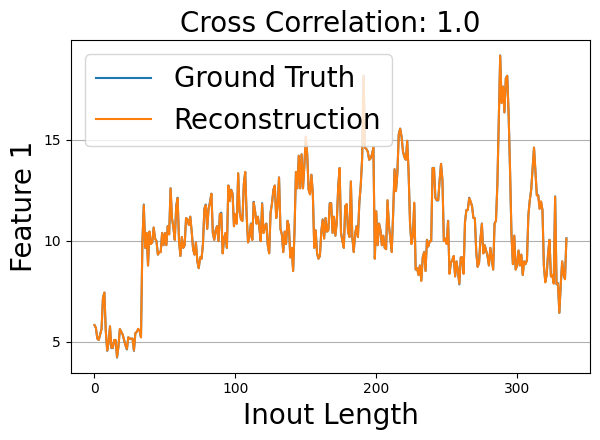

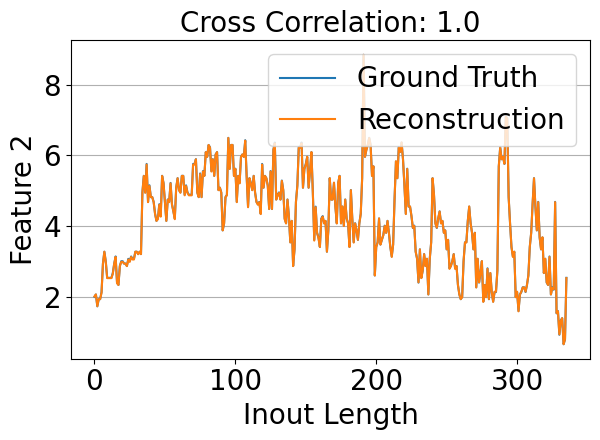

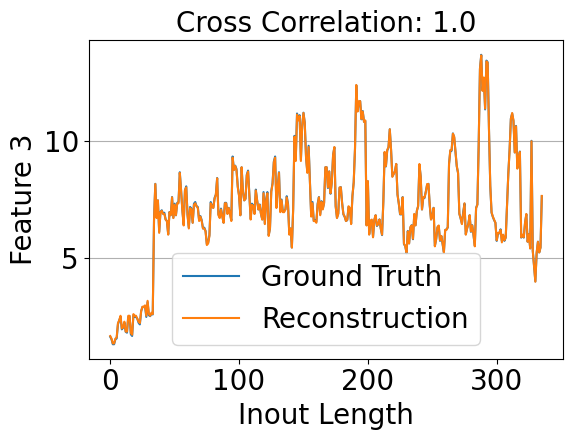

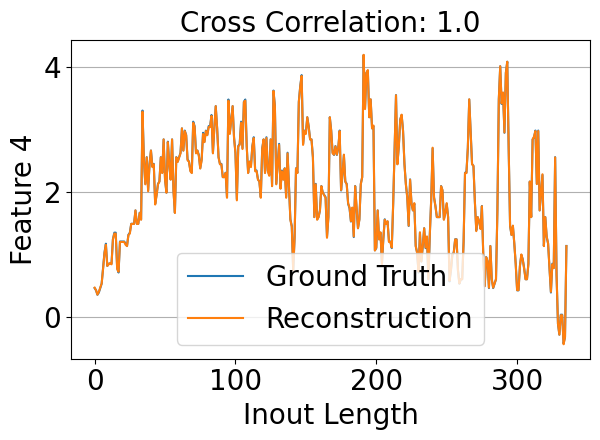

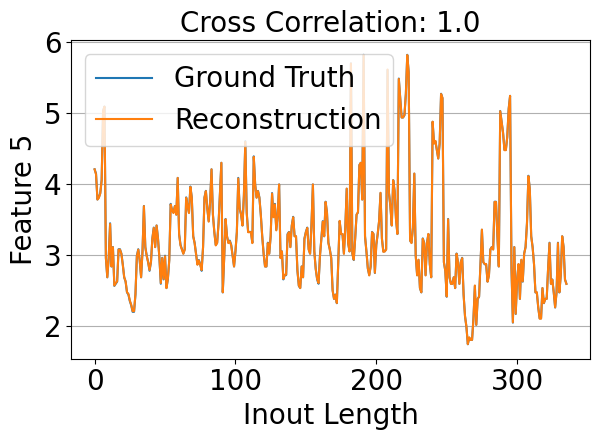

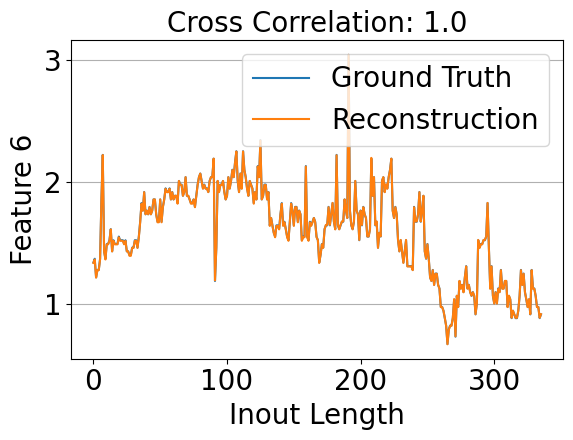

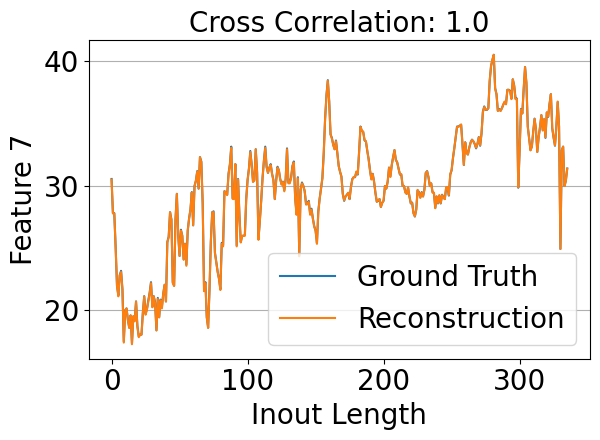

###############################
0.00023449446181028852
0.00935139222201727


In [10]:
if task_tpye == "classification":
    if data_name == 'eeg-eye-state':

        # Initialize the StandardScaler
        scaler = StandardScaler()
        # Fit the scaler to the training data and transform it
        clean_data_frame_second_normalized = scaler.fit_transform(clean_data_frame_second)
        data_labels = data_df['eyeDetection'].to_numpy()

        total_seg_num = int(len(data_labels) / seg_length)

        X_data = np.zeros([total_seg_num, seg_length, 14], dtype=float)
        y_data = np.zeros([total_seg_num], dtype=int)

        seg_num = 0
        for i_seg in range(total_seg_num):
            X_data[seg_num, :, :] = clean_data_frame_second_normalized[i_seg * seg_length:(i_seg + 1) * seg_length, :-1]
            temp_a = data_labels[i_seg * seg_length:(i_seg + 1) * seg_length]
            # print(temp_a)
            if np.mean(temp_a) > 0.5:
                y_data[seg_num] = 1
            seg_num += 1

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        from fABBA import JABBA
        jabba = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)

        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list)
        reconstruction = jabba.inverse_transform(symbols)
        reconst_same_shape = jabba.recast_shape(reconstruction)  # recast into original shape

        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[10])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))

        index_plot = 2
        for i_plot in range(14):
            #         plt.subplot(1, 7, i_plot+1)
            plt.plot(X_data[index_plot, :, i_plot], label='Ground Truth')
            plt.plot(reconst_same_shape[index_plot, :, i_plot], label='Reconstruction')

            # Cross_Correlation = cross_correlation(X_data[i_plot, :], reconstruction[i_plot])
            # plt.rcParams.update({'font.size': 20})
            # plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

            plt.title('The length of symbols: ' + str(len(symbols[index_plot])), fontsize=20)
            plt.xlabel('Inout Length', fontsize=20)
            plt.ylabel('Feature ' + str(i_plot + 1), fontsize=20)

            plt.legend(fontsize=12)
            plt.grid(True, axis='y')
            plt.tight_layout()
#             plt.savefig('Compression_Reproduction_img_S' + data_name + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()


        symbols_convert = []
        for i_data in range(len(symbols)):
            # print(i_data)
            symbols_convert.append(listToString(list(symbols[i_data])))

        train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = train_test_split(
            symbols_convert, y_data, test_size=0.2)

    elif data_name == 'ptbdb':


        jabba = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)

        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler to the training data and transform it
        X_data = scaler.fit_transform(X_data)
        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list)
        # reconstruction = jabba.inverse_transform(symbols)
        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[100])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))

        symbols_convert = []
        for i_data in range(len(symbols)):
            symbols_convert.append(listToString(list(symbols[i_data])))

        train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = train_test_split(
            symbols_convert, y_data, test_size=0.2)

    elif data_name == 'fnirs':

        ###############   fnirs data   ###############

        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        X_data_temp = scaler.fit_transform(X_data_temp)
        X_data = np.reshape(X_data_temp, (X_data.shape[0], X_data.shape[1], X_data.shape[2]))

        # X_data = np.transpose(X_data, (0, 2, 1))
        jabba = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)

        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list)
        reconstruction = jabba.inverse_transform(symbols)
        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[100])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))

        symbols_convert = []
        for i_data in range(len(symbols)):
            symbols_convert.append(listToString(list(symbols[i_data])))

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        train_data_symbolic_temp, test_data_symbolic, train_target_symbolic, test_target_symbolic = \
            symbols_convert[:train_length], symbols_convert[train_length:], y_data[:train_length], y_data[train_length:]

        train_data_symbolic = []
        arranged_seq = np.random.randint(len(train_target_symbolic), size=len(train_target_symbolic))
        for i_arranged_seq in arranged_seq:
            train_data_symbolic.append(train_data_symbolic_temp[i_arranged_seq])
        train_target_symbolic = train_target_symbolic[arranged_seq]

    elif data_name == 'mitbih':

        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler to the training data and transform it
        X_data = scaler.fit_transform(X_data)

        jabba = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=ABBA_scl, verbose=1)

        symbols = jabba.fit_transform(X_data, alphabet_set=vocab_list_new)
        # reconstruction = jabba.inverse_transform(symbols)
        print('##############################################################')
        print("The length of one symbols element is:" + str(len(symbols[100])))
        print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))


        symbols_convert = []
        for i_data in range(len(symbols)):
            # print(i_data)
            symbols_convert.append(listToString(list(symbols[i_data])))

        from sklearn.utils.class_weight import compute_class_weight
        label_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

        # train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = \
        #     symbols_convert[:train_length], symbols_convert[train_length:], y_data[:train_length], y_data[train_length:]

        # train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = \
        #     symbols_convert[:5000], symbols_convert[6000:8500], y_data[:5000], y_data[6000:8500]
        train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = train_test_split(
            symbols_convert, y_data, test_size=0.2)

    data_TS = DatasetDict({
        'train': Dataset.from_dict({'text_outputs': train_target_symbolic, 'text_inputs': train_data_symbolic}),
        'val': Dataset.from_dict({'text_outputs': test_target_symbolic, 'text_inputs': test_data_symbolic})
    })

#     model_tokenized_datasets = data_TS.map(model_preprocessing_function, batched=True)
#     model_tokenized_datasets.set_format("torch")

#     project = "ts-finetune-" + data_name
#     # b-instruct-v0.1-h
#     run_name = model_name + "-" + project
#     output_dir = "./" + run_name


    output_scaler = open(str(model_name + "_" + data_name + "-Scaler_Pre" + "_save.pkl"), 'wb')
    output_jabba = open(str(model_name + "_" + data_name + "-ABBA_Pre" + "_save.pkl"), 'wb')

    str1 = pickle.dumps(scaler)
    output_scaler.write(str1)
    output_scaler.close()

    str2 = pickle.dumps(qabba)
    output_jabba.write(str2)
    output_jabba.close()

elif task_tpye == "regression":
    
    ###############   Monash Regression data   ###############
    data_scaled = process_data(data_all, normalise=norm, min_len=min_len)

    from fABBA import JABBA
    jabba = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=ABBA_scl, verbose=0)
    
    # symbols = jabba.fit_transform(data_scaled)
    symbols = jabba.fit_transform(data_scaled, alphabet_set=vocab_list)
    reconstruction = jabba.inverse_transform(symbols)
    reconst_same_shape = jabba.recast_shape(reconstruction)  # recast into original shape
    
    index_plot = 2
    for i_plot in range(14):
        #         plt.subplot(1, 7, i_plot+1)
        plt.plot(data_scaled[i_plot, :, :], label='Ground Truth')
        plt.plot(reconst_same_shape[i_plot, :, :], label='Reconstruction')

        # Cross_Correlation = cross_correlation(X_data[i_plot, :], reconstruction[i_plot])
        # plt.rcParams.update({'font.size': 20})
        # plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

        plt.title('The length of symbols: ' + str(len(symbols[index_plot])), fontsize=20)
        plt.xlabel('Inout Length', fontsize=20)
        plt.ylabel('Feature ' + str(i_plot + 1), fontsize=20)

        plt.legend(fontsize=12)
        plt.grid(True, axis='y')
        plt.tight_layout()
#         plt.savefig('Compression_Reproduction_img_S' + data_name + '_Feature' + str(i_plot) + '.jpg')
        plt.show()
        plt.close()

            
    print('##############################################################')
    print("[{}] Task: {}".format(model_name, data_name))
    print("The length of used symbols is:" + str(jabba.parameters.centers.shape[0]))


    symbols_convert = []
    for i_data in range(len(symbols)):
        symbols_convert.append(listToString(list(symbols[i_data])))

    train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = \
        symbols_convert[:train_test_split[0]], symbols_convert[train_test_split[0]:], \
        target_scaled[:train_test_split[0]], target_scaled[train_test_split[0]:]

    data_TS = DatasetDict({
        'train': Dataset.from_dict({'text_outputs': train_target_symbolic, 'text_inputs': train_data_symbolic}),
        'val': Dataset.from_dict({'text_outputs': test_target_symbolic, 'text_inputs': test_data_symbolic})
    })

    
elif task_tpye == "forecasting":

#     qabba = JABBA(tol=0.000037, init='agg', alpha=0.000037, scl=3, verbose=0)  #  MinMaxScaler
    #     qabba = JABBA(tol=0.0001117541, init='agg', alpha=0.0001117541, scl=3, verbose=0)
    #     qabba = JABBA(tol=0.0000408066, init='agg', alpha=0.0000408066, scl=3, verbose=0)  #  StandardScaler -> ETTh1  len=24
    #     qabba = JABBA(tol=0.000040838, init='agg', alpha=0.000040838, scl=3, verbose=0)  #  StandardScaler -> ETTh1  len=96
    # qabba = JABBA(tol=0.000040838, init='agg', alpha=0.000040838, scl=3,
    #               verbose=0)  # StandardScaler -> ETTh1  len=168
    qabba = JABBA(tol=0.01, init='agg', alpha=0.01, scl=3, verbose=0)  #  StandardScaler -> ETTh1  len=168
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    #############################################  Train Data  #############################################
    train_data = df_data[border1s[0]:border2s[0]]
    scaler.fit(train_data.values)
    train_data_transformed = scaler.transform(train_data)

    X_Train_data_patch = np.zeros([train_data_transformed.shape[0] - (seq_len_pre + seq_len_post), seq_len_pre, train_data_transformed.shape[1]], dtype=float)
    Y_Train_data_patch = np.zeros([train_data_transformed.shape[0] - (seq_len_pre + seq_len_post), seq_len_post, train_data_transformed.shape[1]], dtype=float)
    for i_data_patch in range(train_data_transformed.shape[0] - (seq_len_pre + seq_len_post)):
        X_Train_data_patch[i_data_patch, :, :] = train_data_transformed[i_data_patch:i_data_patch + seq_len_pre, :]
        Y_Train_data_patch[i_data_patch, :, :] = train_data_transformed[i_data_patch + seq_len_pre:i_data_patch + seq_len_pre + seq_len_post, :]

    symbols_train_data = []
    symbols_train_data = qabba.fit_transform(X_Train_data_patch, alphabet_set=vocab_list, llm_split='Pre')
    reconstruction_train_data = qabba.inverse_transform(symbols_train_data)
    train_data_same_shape = qabba.recast_shape(reconstruction_train_data)  # recast into original shape

    symbols_train_target = []
    symbols_train_target, params_train_target = qabba.transform(Y_Train_data_patch, llm_split='Post')
    reconstruction_train_target = qabba.inverse_transform(symbols_train_target, params_train_target)
    train_target_same_shape = qabba.recast_shape(reconstruction_train_target, recap_shape=Y_Train_data_patch.shape)  # recast into original shape

    print('##############################################################')
    print("The length of used symbols is:" + str(qabba.parameters.centers.shape[0]))

    train_data_symbolic = []
    for i_data in range(len(symbols_train_data)):
        train_data_symbolic.append(listToString(list(symbols_train_data[i_data])))

    train_target_symbolic = []
    for i_data in range(len(symbols_train_target)):
        train_target_symbolic.append(listToString(list(symbols_train_target[i_data])))

    arranged_seq = np.random.randint(len(train_data_symbolic), size=int(len(train_data_symbolic) * 0.2))

    val_data_symbolic = [train_data_symbolic[index] for index in arranged_seq]
    val_target_symbolic = [train_target_symbolic[index] for index in arranged_seq]


    data_TS = DatasetDict({
        'train': Dataset.from_dict({'text_outputs': train_target_symbolic, 'text_inputs': train_data_symbolic}),
        'val': Dataset.from_dict({'text_outputs': val_target_symbolic, 'text_inputs': val_data_symbolic}),
    })

    print('#############################  END  #################################')
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    train_length = 1

    Y_recons_all = np.zeros(([train_length, 7 * seq_len_post]), dtype=float)
    Y_true_all = np.zeros(([train_length, 7 * seq_len_post]), dtype=float)

    for i_reconst in range(train_length):


        Y_true_pre = scaler.inverse_transform(X_Train_data_patch[i_reconst, :, :])
        Y_true_post = scaler.inverse_transform(Y_Train_data_patch[i_reconst, :, :])

        Y_recons_pre = scaler.inverse_transform(train_data_same_shape[i_reconst, :, :])
        Y_recons_post = scaler.inverse_transform(train_target_same_shape[i_reconst, :, :])

    #     Y_recons = scaler.inverse_transform(train_reconst_same_shape[i_reconst, :, :])
    #     Y_true = scaler.inverse_transform(np.transpose(data_patch[i_reconst, :, :]))


    #     for i_plot in range(data.shape[1]):
        for i_plot in range(7):
    #         plt.subplot(1, 7, i_plot+1)

            plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true_post[:, i_plot]), axis=0), label='Ground Truth')
            plt.plot(np.concatenate((Y_recons_pre[:, i_plot], Y_recons_post[:, i_plot]), axis=0), label='Reconstruction')

            Cross_Correlation = cross_correlation(np.concatenate((Y_true_pre[:, i_plot], Y_true_post[:, i_plot]), axis=0),np.concatenate((Y_recons_pre[:, i_plot], Y_recons_post[:, i_plot]), axis=0))
            plt.rcParams.update({'font.size': 20})
            plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)
            plt.xlabel('Inout Length', fontsize=20)
            plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

            plt.legend()
            plt.grid(True, axis='y')
            plt.tight_layout()
    #         plt.savefig('Compression_Reproduction_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()

        Y_recons = np.reshape(Y_recons_post, (1, 7 * seq_len_post))
        Y_true = np.reshape(Y_true_post, (1, 7 * seq_len_post))


        Y_true_all[i_reconst, :] = Y_true
        Y_recons_all[i_reconst, :] = Y_recons

    print('###############################') 
    print(mean_squared_error(Y_true_all, Y_recons_all))
    print(mean_absolute_error(Y_true_all, Y_recons_all))
    
    
#     output_scaler = open(str(model_name + "_" + data_name + "-Scaler_Pre" + "_save.pkl"), 'wb')
#     output_jabba = open(str(model_name + "_" + data_name + "-ABBA_Pre" + "_save.pkl"), 'wb')

#     str1 = pickle.dumps(scaler)
#     output_scaler.write(str1)
#     output_scaler.close()

#     str2 = pickle.dumps(qabba)
#     output_jabba.write(str2)
#     output_jabba.close()


else:
    print("No data here!")

    
    



In [9]:

MAX_LENGTH = 512
batch_size = 4

## Loading Alphabet Set:  you can set vocab_list = pretrained tokens or nothing
model_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=MAX_LENGTH,
    padding_side="right",
    truncation=True,
    add_eos_token=True)

model_tokenizer.padding_side = 'right'
model_tokenizer.pad_token = model_tokenizer.eos_token
print(len(model_tokenizer))

mistral_vocab = model_tokenizer.get_vocab()
vocab_list = list(mistral_vocab.keys())


32000


## 3. Processig the Time Series: Scaler and ABBA

First, the ABBA method is used to symbolic approximate the time series;
Second, reconstruct the transformed symbols back to numerical series;
Third, optimize the hyperparameters of ABBA.

### 3.1 Symbolic Approximating on Time Series

### 3.2 Loading Base LLM and QLoRA block

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [11]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Let's now load Mistral - `mistralai/Mistral-7B-v0.1` - using 4-bit quantization!

In [12]:
##  Quantization Coonfig
quantization_config = BitsAndBytesConfig(
    # Load the model with 4-bit quantization
    load_in_4bit=True,
    # Use double quantization
    bnb_4bit_use_double_quant=True,
    # Use 4-bit Normal Float for storing the base model weights in GPU memory
    bnb_4bit_quant_type="nf4",
    # De-quantize the weights to 16-bit (Brain) float before the forward/backward pass
    bnb_4bit_compute_dtype=torch.bfloat16,
)


model_checkpoint = model_name
model_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
model_tokenizer.pad_token_id = model_tokenizer.eos_token_id
model_tokenizer.pad_token = model_tokenizer.eos_token

model_input = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_checkpoint,
    quantization_config=quantization_config,
    device_map="auto"
)

# Data collator for padding a batch of examples to the maximum length seen in the batch
model_data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)

model_input.config.pad_token_id = model_input.config.eos_token_id
model_input = prepare_model_for_kbit_training(model_input)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's load LoRA using 4-bit quantization!

In [13]:
from peft import LoraConfig, get_peft_model

mistral_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=lora_r,  # the dimension of the low-rank matrices
    lora_alpha=lora_alpha,  # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules=target_modules,
    lora_dropout=lora_dropout,  # dropout probability of the LoRA layers
    bias='none',  # wether to train bias weights, set to 'none' for attention layers
    modules_to_save=modules_to_save,
)
 
    
model_input = get_peft_model(model_input, mistral_lora_config)
# Apply the accelerator. You can comment this out to remove the accelerator.
model_input = accelerator.prepare_model(model_input)


model_input.print_trainable_parameters()
model_input = model_input.cuda()

mistral_vocab = model_tokenizer.get_vocab()
vocab_list = list(mistral_vocab.keys())

print('##############################################################')
print("The length of vocabulary list is:" + str(len(vocab_list)))

vocab_list_new = []
for i_vac in vocab_list:
    if '▁' in i_vac:
        vocab_list_new.append(i_vac.replace('▁', ''))
    else:
        vocab_list_new.append(i_vac)


# ##################################################################

# alphabets_list_used = qabba.parameters.alphabets

# added_tokens = []
# for i_add_tokens in range(len(alphabets_list_used)):
#     if alphabets_list_used[i_add_tokens] not in vocab_list:
#         print(alphabets_list_used[i_add_tokens])
#         added_tokens.append(alphabets_list_used[i_add_tokens])
# #         model_tokenizer.add_special_tokens(alphabets_list_used[i_add_tokens])

# model_tokenizer.add_special_tokens({'additional_special_tokens': added_tokens})



trainable params: 173,592,576 || all params: 7,415,324,672 || trainable%: 2.3410
##############################################################
The length of vocabulary list is:32000


### 3.3 Tokenization of Input Time Series

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


Setup the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning):

And convert each sample into a prompt that I found from [this notebook](https://github.com/samlhuillier/viggo-finetune/blob/main/llama/fine-tune-code-llama.ipynb).

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).


Check that a sample has the max length, i.e. 512.

In [14]:
def tokenize(prompt):

    result = model_tokenizer(
        prompt,
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()

    return result

if task_tpye == "classification":

    if data_name == 'eeg-eye-state':
        
        project = "QABBA-" + data_name
        run_name = model_name + "-" + project + "-r-" + str(lora_r)
        ###############   EEG Eye State data   ###############
        def generate_and_tokenize_prompt(data_point):
            full_prompt = f"""This is a classification task. Identify the "Eye State" according to the given "Symbolic Series".

            ### Symbolic Series: {data_point["text_inputs"]}

            ### Eye State: {data_point["text_outputs"]}

            """
            return tokenize(full_prompt)


    elif data_name == 'ptbdb':
        ###############   PTB-DB data   ###############
        def generate_and_tokenize_prompt(data_point):
            full_prompt = f"""This is a classification task. Identify the "ECG Abnormality" according to the given "Symbolic Series".

            ### Symbolic Series: {data_point["text_inputs"]}

            ### ECG Abnormality: {data_point["text_outputs"]}

            """
            return tokenize(full_prompt)



    elif data_name == 'fnirs':
        ###############   fnirs data   ###############
        def generate_and_tokenize_prompt(data_point):
            full_prompt = f"""This is a classification task. Identify the "Working Memory State" according to the given "Symbolic Series".

            ### Symbolic Series: {data_point["text_inputs"]}

            ### Working Memory State: {data_point["text_outputs"]}

            """
            return tokenize(full_prompt)


    elif data_name == 'mitbih':
        ###############   MIT-BIH data   ###############
        def generate_and_tokenize_prompt(data_point):
            full_prompt = f"""This is a classification task. Identify the "Working Memory State" according to the given "Symbolic Series".

            ### Symbolic Series: {data_point["text_inputs"]}

            ### Working Memory State: {data_point["text_outputs"]}

            """
            return tokenize(full_prompt)



elif task_tpye == "regression":
     
    project = "QABBA-" + data_name
    run_name = model_name + "-" + project + "-r-" + str(lora_r)
    ###############   Monash Regression data   ###############
    def generate_and_tokenize_prompt(data_point):
        full_prompt = f"""This is a regression task. Predicting the "Results" according to the given "Symbolic Series".

        ### Symbolic Series: {data_point["text_inputs"]}

        ### Results: {data_point["text_outputs"]}

        """
        return tokenize(full_prompt)


elif task_tpye == "forecasting":
    
    project = "QABBA-" + data_name
    run_name = model_name + "-" + project + "-r-" + str(lora_r)
    ###############   ETT Forecasting data   ###############
    def generate_and_tokenize_prompt(data_point):
        full_prompt = f"""This is a forecasting task. Forecasting the "Results" according to the given "Symbolic Series".

        ### Symbolic Series: {data_point["text_inputs"]}

        ### Results: {data_point["text_outputs"]}

        """
        return tokenize(full_prompt)


else:
    print("No data here!")


In [15]:

# def tokenize(data_point):
#     model_inputs  = model_tokenizer(
#         data_point["text_inputs"],
#         truncation=True,
#         padding='max_length',
#         max_length=MAX_LENGTH,
#     )
    
#     result  = model_tokenizer(
#         data_point["text_outputs"],
#         truncation=True,
#         padding='max_length',
#         max_length=MAX_LENGTH,
#     )
    
#     model_inputs ["labels"] = result["input_ids"].copy()
#     return model_inputs

# #     result["labels"] = result["input_ids"].copy()
# #     return result



# tokenized_train_dataset = data_TS['train'].map(generate_and_tokenize_prompt, batched=True)
# tokenized_val_dataset = data_TS['val'].map(generate_and_tokenize_prompt, batched=True)

tokenized_train_dataset = data_TS['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = data_TS['val'].map(generate_and_tokenize_prompt)

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")

model_data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)


Map:   0%|          | 0/8304 [00:00<?, ? examples/s]

Map:   0%|          | 0/1660 [00:00<?, ? examples/s]

In [16]:
lora_r

16

We can see it doesn't do very well out of the box.

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=8` and `lora_alpha=16` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

See how the model looks different now, with the LoRA adapters added:


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [17]:
# !pip install -q wandb -U

# import wandb, os
# wandb.login()

# wandb_project = "viggo-finetune"
# if len(wandb_project) > 0:
#     os.environ["WANDB_PROJECT"] = wandb_project

## 4. Run Training!

I used 500 steps, but I found the model should have trained for longer as it had not converged by then, so I upped the steps to 1000 below.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-finetune-viggo`) as your final model in step 6 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [18]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [19]:
import transformers
from datetime import datetime

output_dir = "./" + run_name

num_epochs = 1

trainer = transformers.Trainer(
    model=model_input,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=4,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        learning_rate=2e-4, # Want about 10x smaller than the Mistral learning rate
        bf16=False,
        optim="paged_adamw_8bit",
        num_train_epochs=num_epochs,
        weight_decay=0.00005,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_dir="./logs",
        load_best_model_at_end=True,
        report_to="wandb",
        save_total_limit = 1,
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(model_tokenizer, mlm=False),
)

model_input.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chengkang520 (cheng_nlp). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.827100,0.048659


TrainOutput(global_step=519, training_loss=0.8270562379576107, metrics={'train_runtime': 12208.8081, 'train_samples_per_second': 0.68, 'train_steps_per_second': 0.043, 'total_flos': 1.8247683778648474e+17, 'train_loss': 0.8270562379576107, 'epoch': 1.0})

##  ******************** 5. Drum Roll... Try the Trained Model!  ******************** 

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Mistral model from the Huggingface Hub:


In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

model_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=MAX_LENGTH,
    padding_side="right",
    truncation=True,
    add_eos_token=True,
)

model_tokenizer.padding_side = 'right'
model_tokenizer.pad_token = model_tokenizer.eos_token
print(len(model_tokenizer))

mistral_vocab = model_tokenizer.get_vocab()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

32000


Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [21]:
from peft import PeftModel
import os

project = "QABBA-" + data_name
run_name = model_name + "-" + project + "-r-" + str(lora_r)

output_dir = "./" + run_name
peft_file = os.listdir(output_dir)
ft_model = PeftModel.from_pretrained(model, output_dir + "/" + peft_file[0])



# ft_model = PeftModel.from_pretrained(model, 'llama2-7B-ts-finetune-ETTh1-r16-Pre168-Post168' + "/" + peft_file[0])


In [22]:
os.listdir(output_dir)

['checkpoint-519']

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [23]:


if task_tpye == "classification":

    print("Classification Tasks!")

        
   # qabba_load = JABBA(tol=0.000040837, init='agg', alpha=0.000040837, scl=3, verbose=0)  #  StandardScaler -> ETTh1  len=168

    # with open("llama2-7B_ETTh1-ABBA_Pre168_Post168_save.pkl", 'rb') as file:
    #     qabba_load = pickle.loads(file.read())

    # scaler_load = StandardScaler()
    # with open("llama2-7B_ETTh1-Scaler_Pre168_Post168_save.pkl", 'rb') as file:
    #     scaler_load = pickle.loads(file.read())


    qabba_load = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=3, verbose=1)
    with open(output_jabba, 'rb') as file:
        qabba_load = pickle.loads(file.read())

    scaler_load = StandardScaler()
    with open(output_scaler, 'rb') as file:
        scaler_load = pickle.loads(file.read())


elif task_tpye == "regression":
     
    print("Regression Tasks!")

       
    for i_test in range(5):#range(len(data_TS['val']['text_inputs'])):
        
        eval_tokenizer = f"""This is a regression task. Predicting the "Results" according to the given "Symbolic Series".

        ### Symbolic Series: {data_TS['val']['text_inputs'][i_test]}

        ### Results:

        """
        print('#######################################################################')
        model_input_text = model_tokenizer(eval_tokenizer, return_tensors="pt").to('cuda')

        temp_out = model_tokenizer.decode(
            ft_model.generate(
                **model_input_text,
                max_new_tokens=MAX_LENGTH,
                max_length=MAX_LENGTH,
                repetition_penalty=1.7,
                temperature=0.0,
            )[0],
            skip_special_tokens=True
        )
        print(temp_out)      
        
        
    
elif task_tpye == "forecasting":
    
    print("Forecasting Tasks!")
    
    qabba_load = JABBA(tol=ABBA_tol, init=ABBA_init, alpha=ABBA_alpha, scl=3, verbose=1)
    with open(output_jabba, 'rb') as file:
        qabba_load = pickle.loads(file.read())

    scaler_load = StandardScaler()
    with open(output_scaler, 'rb') as file:
        scaler_load = pickle.loads(file.read())
            

    #############################################  Test Data  #############################################
    test_data = df_data[border2s[0]:border2s[2]]
    test_data_transformed = scaler_load.transform(test_data.values)


    X_Test_data_patch = np.zeros([test_data_transformed.shape[0] - (seq_len_pre + seq_len_post), seq_len_pre, test_data_transformed.shape[1]], dtype=float)
    Y_Test_data_patch = np.zeros([test_data_transformed.shape[0] - (seq_len_pre + seq_len_post), seq_len_post, test_data_transformed.shape[1]], dtype=float)
    for i_data_patch in range(test_data_transformed.shape[0] - (seq_len_pre + seq_len_post)):
        X_Test_data_patch[i_data_patch, :, :] = test_data_transformed[i_data_patch:i_data_patch + seq_len_pre, :]
        Y_Test_data_patch[i_data_patch, :, :] = test_data_transformed[i_data_patch + seq_len_pre:i_data_patch + seq_len_pre + seq_len_post, :]

    symbols_test_data = []
    symbols_test_data, params_test_data = qabba_load.transform(X_Test_data_patch, llm_split='Post')
    reconstruction_test_data = qabba_load.inverse_transform(symbols_test_data, params_test_data)
    test_data_same_shape = qabba_load.recast_shape(reconstruction_test_data, recap_shape=X_Test_data_patch.shape, llm_split='Post')  # recast into original shape

    symbols_test_target = []
    symbols_test_target, params_test_target = qabba_load.transform(Y_Test_data_patch, llm_split='Post')
    reconstruction_test_target = qabba_load.inverse_transform(symbols_test_target, params_test_target)
    test_target_same_shape = qabba_load.recast_shape(reconstruction_test_target, recap_shape=Y_Test_data_patch.shape, llm_split='Post')  # recast into original shape

    print('##############################################################')
    print("The length of used symbols is:" + str(qabba_load.parameters.centers.shape[0]))

    test_data_symbolic = []
    for i_data in range(len(symbols_test_data)):
        test_data_symbolic.append(listToString(list(symbols_test_data[i_data])))

    test_target_symbolic = []
    for i_data in range(len(symbols_test_target)):
        test_target_symbolic.append(listToString(list(symbols_test_target[i_data])))

else:
    print("No data here!")


Forecasting Tasks!


NameError: name 'output_jabba' is not defined

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

test_length = 1

Y_recons_all = np.zeros(([test_length, 7 * seq_len_post]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len_post]), dtype=float)

for i_reconst in range(test_length):
    
   
    Y_true_pre = scaler_load.inverse_transform(X_Test_data_patch[i_reconst, :, :])
    Y_true_post = scaler_load.inverse_transform(Y_Test_data_patch[i_reconst, :, :])
    
    Y_recons_pre = scaler_load.inverse_transform(test_data_same_shape[i_reconst, :, :])
    Y_recons_post = scaler_load.inverse_transform(test_target_same_shape[i_reconst, :, :])

#     Y_recons = scaler.inverse_transform(train_reconst_same_shape[i_reconst, :, :])
#     Y_true = scaler.inverse_transform(np.transpose(data_patch[i_reconst, :, :]))

    
#     for i_plot in range(data.shape[1]):
    for i_plot in range(7):
#         plt.subplot(1, 7, i_plot+1)
        
        plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true_post[:, i_plot]), axis=0), label='Ground Truth')
        plt.plot(np.concatenate((Y_recons_pre[:, i_plot], Y_recons_post[:, i_plot]), axis=0), label='Reconstruction')

        Cross_Correlation = cross_correlation(np.concatenate((Y_true_pre[:, i_plot], Y_true_post[:, i_plot]), axis=0),np.concatenate((Y_recons_pre[:, i_plot], Y_recons_post[:, i_plot]), axis=0))
        plt.rcParams.update({'font.size': 20})
        plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)
        plt.xlabel('Inout Length', fontsize=20)
        plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
#         plt.savefig('Compression_Reproduction_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
        plt.show()
        plt.close()
   
    Y_recons = np.reshape(Y_recons_post, (1, 7 * seq_len_post))
    Y_true = np.reshape(Y_true_post, (1, 7 * seq_len_post))
   
    
    Y_true_all[i_reconst, :] = Y_true
    Y_recons_all[i_reconst, :] = Y_recons

print('###############################') 
print(mean_squared_error(Y_true_all, Y_recons_all))
print(mean_absolute_error(Y_true_all, Y_recons_all))

In [ ]:
model_tokenizer('▁▁▁▁▁▁▁▁▁', return_tensors="pt")

In [ ]:
model_tokenizer('ser', return_tensors="pt")['input_ids']

In [ ]:
model_tokenizer.pad_token_id = model_tokenizer.eos_token_id

test_length = 4
plus_seg = 200
model_output = []
for i_test in range(test_length):#len(data_TS['test'])):

    test_prompt = f"""Generate a Series {test_data_symbolic[i_test+plus_seg]} ### """

    print('###################################  Model Outputs  ####################################')
#     model_input = model_tokenizer(test_tokenize_prompt(data_TS['test'][i_test]), return_tensors="pt").to("cuda")
    model_input = model_tokenizer(test_prompt, return_tensors="pt").to("cuda")

    temp_out = model_tokenizer.decode(
        ft_model.generate(
            **model_input, 
            max_new_tokens=int(MAX_LENGTH_post*2), 
            max_length=int((MAX_LENGTH_pre+MAX_LENGTH_post)*2),
            repetition_penalty=1.9,
            temperature=0.0,
        )[0],
        skip_special_tokens=True
    )
    print(temp_out)
    model_output.append(temp_out)



In [ ]:

# model_output = model_output[1:]

## TODO 
#  Tips1: 调小 max_new_tokens，然后使用 tokenizer 进行拆分，再追溯回去

symbols_LLM_input = []
symbols_LLM_output = []

model_output_list1_processed = []
model_output_list2_processed = []

for i_out in range(test_length):
    
    model_output_list1 = model_output[i_out].split(' ### ')[0].split(' ')[3:-1]

    test_blank_index = []
    for i_list in range(len(model_output_list1)-1):
        if model_output_list1[i_list] is '' and model_output_list1[i_list-1] is '' and model_output_list1[i_list+1] is '':
            test_blank_index.append(i_list)
    del_index1 = []
    del_index1 = np.array(test_blank_index, dtype=int)
    test_processed = []
    test_processed = [model_output_list1[num] for num, i in enumerate(model_output_list1) if num not in del_index1]

    if len(del_index1) != 0:
        add_blank = []
        for i_add in range(len(test_blank_index)):
            add_blank += '▁'

        add_blank = listToString_blank(add_blank)  
        test_processed.insert(del_index1[0], add_blank)


    test_remove_index = []
    for i_list in range(len(test_processed)-1):
        if test_processed[i_list] is '' and test_processed[i_list+1] is not '':
            test_remove_index.append(i_list)
            test_processed[i_list+1] = '▁' + test_processed[i_list+1]
    del_index1 = []
    del_index1 = np.array(test_remove_index, dtype=int)
    test_processed2 = []
    test_processed2 = [test_processed[num] for num, i in enumerate(test_processed) if num not in del_index1]



    test_blank_index = []
    for i_list in range(len(test_processed2)-1):
        if test_processed2[i_list] is '':
            test_blank_index.append(i_list)

    del_index1 = []
    del_index1 = np.array(test_blank_index, dtype=int)
    model_output_list1_processed = [test_processed2[num] for num, i in enumerate(test_processed2) if num not in del_index1]

#     for i_list in range(len(model_output_list1_processed)):
#         if len(model_tokenizer(model_output_list1_processed[i_list], return_tensors="pt")['input_ids'][0]) > 3:
#             if '▁' in model_output_list1_processed[i_list]:
#     #                 print(i_list)
#                 model_output_list1_processed[i_list] = model_output_list1_processed[i_list][1:]

    symbols_LLM_input.append(model_output_list1_processed)

    
#     print('###################################  Plan A  ####################################')   
#     tokens_output_mistral = model_tokenizer(model_output[i_out].split('###')[1][1:], return_tensors="pt")['input_ids'][0][1:-1]
#     model_output_list2_processed = []
#     for i_find in range(len(tokens_output_mistral)):
#         key_mistral_vocab = find_keys_by_value(mistral_vocab, tokens_output_mistral[i_find])[0]
# #         model_output_list2_processed.append(key_mistral_vocab)
#         if key_mistral_vocab != '▁':
#             model_output_list2_processed.append(key_mistral_vocab)

#     symbols_LLM_output.append(model_output_list2_processed)
    
    
    print('###################################  Plan B  ####################################')  
    split_content = model_output[i_out].split(' ### ')
    split_len = len(split_content)
    model_output_list2 = ''
    if split_len == 2:
        model_output_list2 = model_output[i_out].split(' ### ')[1].split(' ')[2:-1]
    elif split_len > 2:
        for i_split_content in range(split_len-1):
            model_output_list2 = model_output_list2 + split_content[i_split_content+1] + ' ### '


    
    test_blank_index = []
    for i_list in range(len(model_output_list2)-1):
        if model_output_list2[i_list] is '' and model_output_list2[i_list-1] is '' and model_output_list2[i_list+1] is '':
            test_blank_index.append(i_list)
    del_index2 = []
    del_index2 = np.array(test_blank_index, dtype=int)
    test_processed = []
    test_processed = [model_output_list2[num] for num, i in enumerate(model_output_list2) if num not in del_index2]

    if len(del_index2) != 0:
        add_blank = []
        for i_add in range(len(test_blank_index)):
            add_blank += '▁'

        add_blank = listToString_blank(add_blank)  
        test_processed.insert(del_index2[0], add_blank)


    test_remove_index = []
    for i_list in range(len(test_processed)-1):
        if test_processed[i_list] is '' and test_processed[i_list+1] is not '':
            test_remove_index.append(i_list)
            test_processed[i_list+1] = '▁' + test_processed[i_list+1]
    del_index2 = []
    del_index2 = np.array(test_remove_index, dtype=int)
    test_processed2 = []
    test_processed2 = [test_processed[num] for num, i in enumerate(test_processed) if num not in del_index2]



    test_blank_index = []
    for i_list in range(len(test_processed2)-1):
        if test_processed2[i_list] is '':
            test_blank_index.append(i_list)

    del_index2 = []
    del_index2 = np.array(test_blank_index, dtype=int)
    model_output_list2_processed = [test_processed2[num] for num, i in enumerate(test_processed2) if num not in del_index2]

    symbols_LLM_output.append(model_output_list2_processed)
         
            
    model_output_list2_processed_copy = model_output_list2_processed.copy()

    index_num_add = 0
    for i_remove in range(len(model_output_list2_processed_copy)):
        if model_output_list2_processed_copy[i_remove] not in qabba_load.parameters.alphabets:

            tokens_i_remove = model_tokenizer(model_output_list2_processed_copy[i_remove], return_tensors="pt")['input_ids'][0]
            if len(tokens_i_remove) == 2:
                continue

#             print(model_output_list2_processed_copy[i_remove])

            model_output_list2_processed.pop(i_remove + index_num_add)
            index_num_add -= 1

            for i_convert in range(len(tokens_i_remove[1:-1])):
                key_mistral_vocab = find_keys_by_value(mistral_vocab, tokens_i_remove[i_convert+1])[0]
#                 print(key_mistral_vocab)
                model_output_list2_processed.insert(1  + i_remove + index_num_add, key_mistral_vocab)
                index_num_add += 1

    for i_list in range(len(model_output_list2_processed)):
        if model_output_list2_processed[i_list] is '':
#             print(i_list)
            model_output_list2_processed.remove('')
    
    for i_list in range(len(model_output_list2_processed)):
        if len(model_tokenizer(model_output_list2_processed[i_list], return_tensors="pt")['input_ids'][0]) > 3:
            if '▁' in model_output_list2_processed[i_list]:
#                 print(i_list)
                model_output_list2_processed[i_list] = model_output_list2_processed[i_list][1:]
    
    symbols_LLM_output.append(model_output_list2_processed)

In [ ]:
symbols_LLM_input = symbols_LLM_input[2:]
symbols_LLM_output = symbols_LLM_output[2:]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
import itertools
from scipy.interpolate import interp1d

test_length = 4
# test_length = 10

reconst_test_input = qabba_load.inverse_transform(symbols_LLM_input, params_test_data)  # convert into array
reconst_same_shape_input = qabba_load.recast_shape(reconst_test_input, recap_shape=[test_length, seq_len_pre, 7], llm_split='Post') 
# for i_0 in range(reconst_same_shape_input.shape[0]):
#     for i_2 in range(reconst_same_shape_input.shape[2]):
#         reconst_same_shape_input[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
       

reconst_test_output = qabba_load.inverse_transform(symbols_LLM_output, params_test_target)  # convert into array
# reconst_same_shape_output = qabba.recast_shape(reconst_test_output, recap_shape=[test_length, seq_len_post, 7], llm_split='Post')

padded = zip(*itertools.zip_longest(*reconst_test_output, fillvalue=-1))
padded = list(padded)
padded = np.asarray(padded)
reconst_same_shape_output = []
for i_i in range(test_length):
    Temp_ = padded[i_i][:24*7]
    reconst_same_shape_output.append(Temp_)
reconst_same_shape_output = np.asarray(reconst_same_shape_output).reshape([test_length, 24, 7])


# reconst_same_shape_output = np.ones([test_length, 24, 7])
# for i_convert_shape in range(len(reconst_test_output)):
    
#     BB = np.array(reconst_test_output[i_convert_shape])
    
#     x = np.linspace(0, len(BB)-1, num=len(BB))
#     x_pred = np.linspace(0, len(BB)-1, num=24*7*8)

#     f1 = interp1d(x, BB, kind='linear')
#     f2 = interp1d(x, BB, kind='cubic')
    
#     y2 = f2(x_pred)
#     reconst_same_shape_output[i_convert_shape] = np.reshape(y2[0::8], (seq_len_post,7))
    
# for i_0 in range(reconst_same_shape_output.shape[0]):
#     for i_2 in range(reconst_same_shape_output.shape[2]):
#         reconst_same_shape_output[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
      
    
# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len_post]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len_post]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


for i_reconst in range(2):  # test_length


#     Y_recons_pre = scaler.inverse_transform(X_Test_data_patch[i_reconst, :, :])
#     Y_recons_post = scaler.inverse_transform(Y_Test_data_patch[i_reconst, :, :])
    
    Y_true = scaler_load.inverse_transform(Y_Test_data_patch[i_reconst+plus_seg, :, :])
    Y_true_pre = scaler_load.inverse_transform(X_Test_data_patch[i_reconst+plus_seg, :, :])
    
    
#     scaler_output = MinMaxScaler()
    scaler_output = StandardScaler()  ##   DONE the Test
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])  ##  ?????????????????????????   是否需要多個維度叠加在一起？？？？？
    
    Y_pred = scaler_load.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst, :, :]))
    Y_pred_pre = scaler_load.inverse_transform(reconst_same_shape_input[i_reconst, :, :])
#     Y_pred_pre = Y_true_pre


#     Y_pred = scaler_output.transform(reconst_same_shape_output[i_reconst, :, :])
#     Y_pred_pre = reconst_same_shape_input[i_reconst, :, :]

#     Y_true = test_data_patch[i_reconst+plus_seg+seq_len, :, :]
#     Y_true_pre = test_data_patch[i_reconst+plus_seg, :, :]


    for i_plot in range(7):
#         plt.subplot(1, 7, i_plot+1)
        if i_plot >= 3:
            AA = []
            AA = np.concatenate((Y_pred_pre[-2:, i_plot], Y_pred[:, i_plot]), axis=0)

            mean_vibration = np.mean(np.abs(np.diff(AA)))*seq_len_post

            AA_max = np.max(np.abs(np.diff(AA)))
            Y_true_max = np.mean(np.abs(np.diff(Y_true[:, i_plot])))
            if AA_max > Y_true_max:
                diff_TS = np.diff(AA)
                for i_TS in range(len(AA)-1):
                    if np.abs(diff_TS[i_TS]) > Y_true_max*0.55:
                        AA[i_TS+1:] = AA[i_TS+1:] - 0.55*diff_TS[i_TS]  #  (1.0-Y_true_max/AA_max)

                diff_temp = Y_true_pre[1, i_plot] - Y_pred_pre[1, i_plot]
                Y_pred[:, i_plot] = AA[2:] + diff_temp

        if i_reconst == 0:
            plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true[:, i_plot]), axis=0), label='Ground Truth')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], signal.detrend(Y_pred[:, i_plot])+Y_pred_pre[-1, i_plot]-signal.detrend(Y_pred[:, i_plot])[1]), axis=0), label='Forecasting')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

            plt.plot(np.concatenate((Y_pred_pre[:, i_plot] + diff_temp, Y_pred[:, i_plot]), axis=0), label='Forecasting')


            Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
            plt.rcParams.update({'font.size': 20})
            plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=16)

            n_bins = np.arange(0, seq_len_pre+seq_len_post, 8)
            plt.xticks(n_bins, n_bins, rotation = 30, fontsize=12)
            plt.xlabel('Input Length', fontsize=16)
            plt.ylabel('Feature ' + str(i_plot+1), fontsize=16)

            plt.legend()
            plt.grid(c='r')
            plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()
    print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len_post))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len_post))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################')
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
len(reconst_test_input[0])

In [ ]:
len(symbols_LLM_input)

In [ ]:
np.abs(diff_TS)

In [ ]:
1.0-Y_true_max/AA_max

In [ ]:
np.diff(Y_true[:, 6])

In [ ]:
np.abs(np.diff(Y_pred_pre[:, 6]))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
# test_length = 50

reconst_test_input = qabba.inverse_transform(symbols_LLM_input, test_params)  # convert into array
reconst_same_shape_input = qabba.recast_shape(reconst_test_input) 
# for i_0 in range(reconst_same_shape_input.shape[0]):
#     for i_2 in range(reconst_same_shape_input.shape[2]):
#         reconst_same_shape_input[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
       

reconst_test_output = qabba.inverse_transform(symbols_LLM_output, test_params)  # convert into array
reconst_same_shape_output = qabba.recast_shape(reconst_test_output)
# for i_0 in range(reconst_same_shape_output.shape[0]):
#     for i_2 in range(reconst_same_shape_output.shape[2]):
#         reconst_same_shape_output[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
        
# reconst_same_shape_output = np.ones_like(reconst_same_shape_input)
# for i_convert_shape in range(len(reconst_test_output)):
    
#     BB = np.array(reconst_test_output[i_convert_shape])
    
#     x = np.linspace(0, len(BB)-1, num=len(BB))
#     x_pred = np.linspace(0, len(BB)-1, num=24*7*3)

#     f1 = interp1d(x, BB, kind='linear')
#     f2 = interp1d(x, BB, kind='cubic')
    
#     y2 = f2(x_pred)
# #     reconst_same_shape_output[i_convert_shape] = np.reshape(y2[0::8], (seq_len,7))
#     reconst_same_shape_output[i_convert_shape] = np.reshape(y2[:seq_len*7], (seq_len,7))
 
 
    
# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


for i_reconst in range(test_length):

#     scaler_output = MinMaxScaler()
    scaler_output = StandardScaler()  ##   DONE the Test
    
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])  ##  ?????????????????????????   是否需要多個維度叠加在一起？？？？？
    
    Y_pred = scaler.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst, :, :]))
    Y_pred_pre = scaler.inverse_transform(reconst_same_shape_input[i_reconst, :, :])

    Y_true = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg+seq_len, :, :])
    Y_true_pre = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg, :, :])
    
#     Y_pred = scaler_output.transform(reconst_same_shape_output[i_reconst, :, :])
#     Y_pred_pre = reconst_same_shape_input[i_reconst, :, :]

#     Y_true = test_data_patch[i_reconst+plus_seg+seq_len, :, :]
#     Y_true_pre = test_data_patch[i_reconst+plus_seg, :, :]

    if i_reconst == 0:
        for i_plot in range(7):
    #         plt.subplot(1, 7, i_plot+1)

            AA = []
            AA = np.concatenate((Y_pred_pre[-2:, i_plot], Y_pred[:, i_plot]), axis=0)

            mean_vibration = np.mean(np.abs(np.diff(AA)))*seq_len
            
            AA_max = np.max(np.abs(np.diff(AA)))
            Y_true_max = np.max(np.abs(np.diff(Y_true[:, i_plot])))
            if AA_max > Y_true_max:
                diff_TS = np.diff(AA)
                for i_TS in range(len(AA)-1):
                    if np.abs(diff_TS[i_TS]) > Y_true_max*0.7:
                        AA[i_TS+1:] = AA[i_TS+1:] - 0.7*diff_TS[i_TS]  #  (1.0-Y_true_max/AA_max)

                diff_temp = Y_true_pre[1, i_plot] - Y_pred_pre[1, i_plot]
                Y_pred[:, i_plot] = AA[2:] + diff_temp

            plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true[:, i_plot]), axis=0), label='Ground Truth')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], signal.detrend(Y_pred[:, i_plot])+Y_pred_pre[-1, i_plot]-signal.detrend(Y_pred[:, i_plot])[1]), axis=0), label='Forecasting')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

            plt.plot(np.concatenate((Y_pred_pre[:, i_plot] + diff_temp, Y_pred[:, i_plot]), axis=0), label='Forecasting')


            Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
            plt.rcParams.update({'font.size': 20})
            plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

            n_bins = np.arange(0, seq_len*2, 8)
            plt.xticks(n_bins, n_bins, rotation = 30, fontsize=10)
            plt.xlabel('Inout Length', fontsize=20)
            plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

            plt.legend()
            plt.grid(c='r')
    #         plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()
        print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################') 
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
24*7

In [ ]:
reconst_same_shape_output.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
# test_length = 50

reconst_test_input = qabba.inverse_transform(symbols_LLM_input, test_params)  # convert into array
reconst_same_shape_input = qabba.recast_shape(reconst_test_input) 
# for i_0 in range(reconst_same_shape_input.shape[0]):
#     for i_2 in range(reconst_same_shape_input.shape[2]):
#         reconst_same_shape_input[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
       

reconst_test_output = qabba.inverse_transform(symbols_LLM_output, test_params)  # convert into array
reconst_same_shape_output = qabba.recast_shape(reconst_test_output)
# for i_0 in range(reconst_same_shape_output.shape[0]):
#     for i_2 in range(reconst_same_shape_output.shape[2]):
#         reconst_same_shape_output[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
        

    
# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


for i_reconst in range(test_length):

#     scaler_output = MinMaxScaler()
    scaler_output = StandardScaler()  ##   DONE the Test
    
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])  ##  ?????????????????????????   是否需要多個維度叠加在一起？？？？？
    
    Y_pred = scaler.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst, :, :]))
    Y_pred_pre = scaler.inverse_transform(reconst_same_shape_input[i_reconst, :, :])

    Y_true = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg+seq_len, :, :])
    Y_true_pre = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg, :, :])
    
#     Y_pred = scaler_output.transform(reconst_same_shape_output[i_reconst, :, :])
#     Y_pred_pre = reconst_same_shape_input[i_reconst, :, :]

#     Y_true = test_data_patch[i_reconst+plus_seg+seq_len, :, :]
#     Y_true_pre = test_data_patch[i_reconst+plus_seg, :, :]

    if i_reconst == 0:
        for i_plot in range(7):

            plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true[:, i_plot]), axis=0), label='Ground Truth')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], signal.detrend(Y_pred[:, i_plot])+Y_pred_pre[-1, i_plot]-signal.detrend(Y_pred[:, i_plot])[1]), axis=0), label='Forecasting')
    #         plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

            plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')


            Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
            plt.rcParams.update({'font.size': 20})
            plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

            n_bins = np.arange(0, seq_len*2, 8)
            plt.xticks(n_bins, n_bins, rotation = 30, fontsize=10)
            plt.xlabel('Inout Length', fontsize=20)
            plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

            plt.legend()
            plt.grid(c='r')
    #         plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()
        print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################') 
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
reconst_test_output[0]

In [ ]:
from scipy.interpolate import interp1d  


BB = reconst_test_output[0]
x = np.linspace(0, 24*7*2, num=10)

In [ ]:
len()

In [ ]:
np.asarray(reconst_test_output[0]).reshape([24, 7])

In [ ]:
signal.detrend(Y_pred[:, 3])

In [ ]:
np.mean(np.abs(signal.detrend(Y_pred) - (Y_true-np.mean(Y_true))))

In [ ]:
Y_pred.shape

In [ ]:
reconst_same_shape_input.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
# test_length = 50


reconst_test_output = qabba.inverse_transform(symbols_LLM_output, test_params)  # convert into array
reconst_same_shape_output = qabba.recast_shape(reconst_test_output)
# reconst_test_output_converted = []
# for i_v in range(len(reconst_test_output)):
#     reconst_test_output_converted.append(signal.detrend(np.array(reconst_test_output[i_v])))
# reconst_same_shape_output = qabba.recast_shape(reconst_test_output_converted) 


reconst_test_input = qabba.inverse_transform(symbols_LLM_input, test_params)  # convert into array
reconst_same_shape_input = qabba.recast_shape(reconst_test_input)


# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


plus_seg = 0
for i_reconst in range(test_length):

    scaler_output = MinMaxScaler()
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])
    
    Y_pred = scaler.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst+plus_seg, :, :]))
    Y_pred_pre = scaler.inverse_transform(reconst_same_shape_input[i_reconst+plus_seg, :, :])
#     Y_true = test_data.values[i_reconst + seq_len:i_reconst + seq_len * 2, :]
    Y_true = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg+seq_len, :, :])
    Y_true_pre = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg, :, :])
    

    if i_reconst == 0:
        for i_plot in range(7):
    #         plt.subplot(1, 7, i_plot+1)
            plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true[:, i_plot]), axis=0), label='Ground Truth')
            plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

            Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
            plt.rcParams.update({'font.size': 20})
    #         plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

            n_bins = np.arange(0, 24*2, 2)
            plt.xticks(n_bins, n_bins, rotation = 30, fontsize=10)
            plt.xlabel('Inout Length', fontsize=20)
            plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

            plt.legend()
            plt.grid(c='r')
    #         plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
            plt.show()
            plt.close()
    print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################') 
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
111

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
# test_length = 50


reconst_test_output = qabba.inverse_transform(symbols_LLM_output, test_params)  # convert into array
reconst_same_shape_output = qabba.recast_shape(reconst_test_output)
# for i_0 in range(reconst_same_shape_input.shape[0]):
#     for i_2 in range(reconst_same_shape_input.shape[2]):
#         reconst_same_shape_output[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
        
reconst_test_input = qabba.inverse_transform(symbols_LLM_input, test_params)  # convert into array
reconst_same_shape_input = qabba.recast_shape(reconst_test_input) 
# for i_0 in range(reconst_same_shape_input.shape[0]):
#     for i_2 in range(reconst_same_shape_input.shape[2]):
#         reconst_same_shape_input[i_0, :, i_2] = signal.detrend(reconst_same_shape_output[i_0, :, i_2])
       

    
# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


plus_seg = 0
for i_reconst in range(test_length):

    scaler_output = MinMaxScaler()
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])
    
    Y_pred = scaler.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst+plus_seg, :, :]))
    Y_pred_pre = scaler.inverse_transform(reconst_same_shape_input[i_reconst+plus_seg, :, :])
#     Y_true = test_data.values[i_reconst + seq_len:i_reconst + seq_len * 2, :]
    Y_true = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg+seq_len, :, :])
    Y_true_pre = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg, :, :])
    

    
    for i_plot in range(7):
#         plt.subplot(1, 7, i_plot+1)
        plt.plot(np.concatenate((Y_true_pre[:, i_plot], signal.detrend(Y_true[:, i_plot])), axis=0), label='Ground Truth')
        plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

        Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
        plt.rcParams.update({'font.size': 20})
#         plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)

        n_bins = np.arange(0, 24*2, 2)
        plt.xticks(n_bins, n_bins, rotation = 30, fontsize=10)
        plt.xlabel('Inout Length', fontsize=20)
        plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

        plt.legend()
        plt.grid(c='r')
#         plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
        plt.show()
        plt.close()
    print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################') 
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
model_output.split('### Series:')[0].split(' ')[10:-2]

In [ ]:
model_output.split('### Series:')[0]

In [ ]:
model_output.split('### Series:')[1]

In [ ]:
len(model_output_INPUT)

In [ ]:
model_output_INPUT_mistral_vocab[16]

In [ ]:
key_mistral_vocab

In [ ]:
def find_keys_by_value(dictionary, value):
    return [key for key, val in dictionary.items() if val == value]


symbols_LLM_input = []
symbols_LLM_output = []
mistral_vocab = model_tokenizer.get_vocab()

test_length = 2

for i_test in range(test_length):#len(data_TS['test'])):

    test_prompt = f"""Generate a Series based on a given Inputs.\n ### Inputs: {test_data_symbolic[i_test]}\n ### Series:"""

    print('###################################  Model Outputs  ####################################')
#     model_input = model_tokenizer(test_tokenize_prompt(data_TS['test'][i_test]), return_tensors="pt").to("cuda")
    model_input = model_tokenizer(test_prompt, return_tensors="pt").to("cuda")

    model_output = model_tokenizer.decode(
        ft_model.generate(
            **model_input, 
            max_new_tokens=MAX_LENGTH*2, 
            max_length=MAX_LENGTH*2,
            repetition_penalty=3.1
        )[0],
        skip_special_tokens=True
    )
    print(model_output)
#     symbols_LLM.append(stringToList(model_output.split('### Series:\n')[1][8:]))
#     symbols_LLM.append(stringToList(model_output))


    model_output_INPUT = model_tokenizer(
        model_output.split('### Series:')[0], 
        return_tensors="pt",
        truncation=True,
        padding=True,
    ).to("cuda")['input_ids'][0]
    model_output_INPUT_mistral_vocab = []

    model_output_OUTPUT = model_tokenizer(
        model_output.split('### Series:')[1], 
        return_tensors="pt",
        truncation=True,
        padding=True,
    ).to("cuda")['input_ids'][0]
    model_output_OUTPUT_mistral_vocab = []

    for i_find in range(len(model_output_INPUT)-1):
        key_mistral_vocab =  find_keys_by_value(mistral_vocab, model_output_INPUT[i_find])[0]
        if key_mistral_vocab != '▁':
            model_output_INPUT_mistral_vocab.append(key_mistral_vocab)
            print(key_mistral_vocab)
    
    for i_find in range(len(model_output_OUTPUT)-1):
        key_mistral_vocab =  find_keys_by_value(mistral_vocab, model_output_OUTPUT[i_find])[0]
        if key_mistral_vocab != '▁':
            model_output_OUTPUT_mistral_vocab.append(key_mistral_vocab)
            print(key_mistral_vocab)
    
    print('###################################  Removing Unknown Symbols  ####################################')
#     for i_remove in range(len(model_output_list2_copy)):
#         if model_output_list2_copy[i_remove] not in qabba.parameters.alphabets:
#             print(model_output_list2_copy[i_remove])
# #             model_output_list2.remove(model_output_list2_copy[i_remove])
#             model_output_list2[i_remove] = model_output_list2[i_remove - 2]

            
#     for i_remove in range(len(model_output_list1_copy)):
#         if model_output_list1_copy[i_remove] not in qabba.parameters.alphabets:
#             print(model_output_list1_copy[i_remove])
#             model_output_list1.remove(model_output_list1_copy[i_remove])
            
#     for i_remove in range(len(model_output_list2_copy)):
#         if model_output_list2_copy[i_remove] not in qabba.parameters.alphabets:
#             print(model_output_list2_copy[i_remove])
#             model_output_list2.remove(model_output_list2_copy[i_remove])
            
    symbols_LLM_input.append(model_output_INPUT_mistral_vocab[16])
    symbols_LLM_output.append(model_output_OUTPUT_mistral_vocab[1:])

    print('###################################  Label Text Inputs and Outputs  ####################################')
    print(test_data_symbolic[i_test])
    print('###################################')
    print(test_target_symbolic[i_test])


In [ ]:
symbols_LLM_input[1]

In [ ]:
symbols_LLM_output[1]

In [ ]:
def find_keys_by_value(dictionary, value):
    return [key for key, val in dictionary.items() if val == value]


symbols_LLM_input = []
symbols_LLM_output = []
mistral_vocab = model_tokenizer.get_vocab()

test_length = 2

for i_test in range(test_length):#len(data_TS['test'])):

    test_prompt = f"""Generate a Series based on a given Inputs.\n ### Inputs: {test_data_symbolic[i_test]}\n ### Series:"""

    print('###################################  Model Outputs  ####################################')
    model_input = model_tokenizer(test_prompt, return_tensors="pt").to("cuda")

    model_output = ft_model.generate(
            **model_input, 
            max_new_tokens=MAX_LENGTH*2, 
            max_length=MAX_LENGTH*2,
            repetition_penalty=3.1
        )[0]
    
    model_output_mistral_vocab = []
    for i_find in range(len(model_output)):
        key_mistral_vocab =  find_keys_by_value(mistral_vocab, model_output[i_find])[0]
        if key_mistral_vocab != '▁':
            model_output_mistral_vocab.append(key_mistral_vocab)


    flag_input = 0
    flag_output = 0
    for i_find in range(len(model_output_mistral_vocab)-1):

        if model_output_mistral_vocab[i_find] == '▁###' and model_output_mistral_vocab[i_find+1] == '▁Input':
            print(i_find)
            flag_input = i_find

        if model_output_mistral_vocab[i_find] == '▁###' and model_output_mistral_vocab[i_find+1] == '▁Series':
            print(i_find)
            flag_output = i_find

    
    symbols_LLM_input.append(model_output_mistral_vocab[flag_input+4:flag_output-1])
    symbols_LLM_output.append(model_output_mistral_vocab[flag_output+4:])


In [ ]:
len(symbols_LLM_input[0])

##### Sweet... it worked! The fine-tuned model now understands the meaning representation!

I hope you enjoyed this tutorial on fine-tuning Mistral. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or on the [Discord channel](https://discord.gg/y9428NwTh3).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# test_length = 50


reconst_test_output = qabba.inverse_transform(symbols_LLM_output, test_params)  # convert into array
reconst_same_shape_output = qabba.recast_shape(reconst_test_output) 

reconst_test_input = qabba.inverse_transform(symbols_LLM_input, test_params)  # convert into array
reconst_same_shape_input = qabba.recast_shape(reconst_test_input) 

# reconst_same_shape = np.zeros(([test_length, 7, seq_len]), dtype=float)

Y_pred_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
Y_true_all = np.zeros(([test_length, 7 * seq_len]), dtype=float)
MAE_result = np.zeros(test_length, dtype=float)
MSE_result = np.zeros(test_length, dtype=float)


plus_seg = 0
for i_reconst in range(test_length):

    scaler_output = MinMaxScaler()
    scaler_output.fit(reconst_same_shape_output[i_reconst, :, :])
    
    Y_pred = scaler.inverse_transform(scaler_output.transform(reconst_same_shape_output[i_reconst+plus_seg, :, :]))
    Y_pred_pre = scaler.inverse_transform(reconst_same_shape_input[i_reconst+plus_seg, :, :])
#     Y_true = test_data.values[i_reconst + seq_len:i_reconst + seq_len * 2, :]
    Y_true = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg+seq_len, :, :])
    Y_true_pre = scaler.inverse_transform(test_data_patch[i_reconst+plus_seg, :, :])
    

    
    for i_plot in range(7):
#         plt.subplot(1, 7, i_plot+1)
        plt.plot(np.concatenate((Y_true_pre[:, i_plot], Y_true[:, i_plot]), axis=0), label='Ground Truth')
        plt.plot(np.concatenate((Y_pred_pre[:, i_plot], Y_pred[:, i_plot]), axis=0), label='Forecasting')

        Cross_Correlation = cross_correlation(Y_pred[:, i_plot], Y_true[:, i_plot])
        plt.rcParams.update({'font.size': 20})
#         plt.title('Cross Correlation: ' + str("{:.3}".format(Cross_Correlation)), fontsize=20)
        plt.xlabel('Inout Length', fontsize=20)
        plt.ylabel('Feature ' + str(i_plot+1), fontsize=20)

        plt.legend()
        plt.grid(True, axis='y')
#         plt.savefig('LLM_Predictor_img_S' + str(i_reconst) + '_Feature' + str(i_plot) + '.jpg')
        plt.show()
        plt.close()
    print('###############################')
    
    Y_pred = np.reshape(Y_pred, (1, 7 * seq_len))
    Y_true = np.reshape(Y_true, (1, 7 * seq_len))
   
    
    Y_pred_all[i_reconst, :] = Y_pred
    Y_true_all[i_reconst, :] = Y_true

    MAE_result[i_reconst] = np.mean(np.abs(Y_pred - Y_true))
    MSE_result[i_reconst] = np.mean(np.power(Y_pred - Y_true, 2))
    
print('###############################') 
print(mean_squared_error(Y_true_all, Y_pred_all))
print(mean_absolute_error(Y_true_all, Y_pred_all))
# print(mean(MSE_result))
# print(mean(MAE_result))



In [ ]:
MAE_result.shape

In [ ]:
mean(MAE_result)